In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

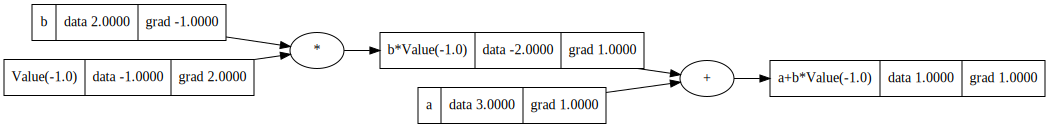

In [23]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label if label != '' else f"Value({data})"

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # allows us to add scalars to a Value object
        out = Value(self.data + other.data, (self, other), '+', label=f"{self.label}+{other.label}")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # allows us to multiply scalars to a Value object
        out = Value(self.data * other.data, (self, other), '*', label=f"{self.label}*{other.label}")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    # fallback if left-hand operand doesn't support __mul__, e.g. 2.0 * Value(3.0)
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}", label=f"{self.label}**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh', label=f"tanh({self.label})")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data  
        e = math.exp(x)
        out = Value(e, (self,), 'exp', label=f"exp({self.label})")

        def _backward():
            self.grad += e * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # Note that although for a simply neuron we could simply use recursive calls to backward on the children
        # this wouldn't work for more complex graphs (e.g. MLP), as we would end up visiting nodes multiple times, effectively
        # summing the gradients from multiple paths. Instead, we need to build a topological ordering of the graph 
        # to ensure that we visit each node only once and only after all its children have been visited.
        # Then we can simply call the _backward function on each node in reverse topological order.
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def draw_graph(self, format='svg', rankdir='LR'):
        def trace(self):
            # build a graph of reachable nodes
            nodes, edges = set(), set()
            def build(v):
                if v not in nodes:
                    nodes.add(v)
                    for child in v._prev:
                        edges.add((child, v))
                        build(child)
            build(self)
            return nodes, edges

        assert rankdir in ['LR', 'TB']
        nodes, edges = trace(self)
        dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
        
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
            if n._op:
                dot.node(name=uid + n._op, label=n._op)
                dot.edge(uid + n._op, uid)
        
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
        return dot
    
a = Value(3.0, label='a')
b = Value(2.0, label='b')
c = a - b
c.backward()
c.draw_graph()

# **Example**

-8.0
children: set() operation: 
children: {Value(data=-6.0), Value(data=10.0)} operation: +
children: {Value(data=4.0), Value(data=-2.0)} operation: *


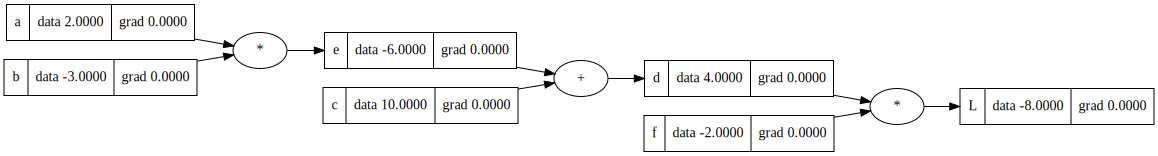

In [3]:
# Building a graph of operations using the Value class
a = Value(2.0, label='a')  
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'; # a.__mul__(b)
d = e + c; d.label = 'd'; # a.__mul__(b).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
print(L.data)

print('children:', a._prev, 'operation:', a._op)
print('children:', d._prev, 'operation:', d._op) # children: value of (a.__mul__(b)) and value of c, stemming from the addition operation
print('children:', L._prev, 'operation:', L._op) # children stemming from the multiplication operation

# draw_graph(L)
L.draw_graph()

## Backpropagation

Applying a forward pass through the graph is simple, we simply compute the output of each node in the graph, starting from the inputs (leaf nodes) and working our way to the output (root node). Once we have the output, we may ask ourselves: How does this output change if we change the value of a node? This is known as the gradient of the output with respect to that node. We can compute this gradient by applying the chain rule, and working our way backwards through the graph (backpropagation).

Intuitively, backpropagation is fairly simple. Let's take for example the function from above $L = d * f = (e + c) * f = ((a * b) + c) * f$. Let's ask ourselves, how a change in $a$ affects $L$. We can see that a change in $a$ affects $L$ by effectively changing the value of its parent $e$. We denote this change in $e$ w.r.t. $a$ as $\frac{\partial e}{\partial a}$. So if that is the amount by which $e$ changes if we change $a$ (by $1$), then how does this propagate towards $L$? Well, a change in $e$ (by $1$) changes $L$ by $\frac{\partial L}{\partial e}$ so by multiplying these two amounts we get that a change in $a$ (by $1$) changes $L$ by the amount $\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \frac{\partial e}{\partial a}$. This in essence is the chain rule. This same thought process can be applied to any node in the graph and hence we find that the gradient of $L$ w.r.t. to any node can simply be computed by multiplying the local gradient of that node, i.e. "How does it affect its parent", with the gradient of its parent node w.r.t. the entire expression. As a consequence, a single backward pass through the graph is sufficient to compute the gradient of $L$ w.r.t. to all nodes in the graph.

How can we now use this gradient information to move the output of our expression $L$ in a desired direction, e.g. down? It turns out that we can simply subtract the gradients of the nodes from their values in order to move the output in the direction of the steepest descent, hence decreasing $L$. This is known as gradient descent.

In [4]:
# Backpropagation
# Manually computing the gradients (backward pass of the computational graph)
L.grad = 1
f.grad = 4
d.grad = -2
a.grad = 6
b.grad = -4
c.grad = -2

# Update the values of the parameters using the gradients
step_size = 0.01
a.data -= step_size * a.grad
b.data -= step_size * b.grad
c.data -= step_size * c.grad
f.data -= step_size * f.grad

# Re-run the forward pass
e = a * b
d = e + c
L = d * f
print(L.data)

-8.726303999999999


# **Applying this to a neuron**

A simple neuron can be described as follows: $y = f(\Sigma_i w_i x_i + b)$. Here $x_i$ are the inputs, $w_i$ are the weights, $b$ is the bias and $y$ is the output. The bias can be viewed as the "trigger-happiness" of the neuron, regardless of the inputs, if the bias is high enough, the neuron will fire. The weights can be viewed as the "importance" of each input. If the weight is high, then the input is important, if the weight is low, then the input is not important. The output of the neuron is then passed through an activation function which is generally some sort of squashing function, e.g. the $\text{sigmoid}$ function or $\text{tanh}$, to produce the final output of the neuron.

Notice in the manual backward pass that we compute below, how easily the gradient flows backwards through a '+' operation, $c = a + b$. This is because the local gradient of an expression $a + b$ is simply $1$ w.r.t. both $a$ and $b$. These local gradients are then multiplied by the gradient of their parent node, i.e. $\partial L / \partial c$ to compute the gradient of $L$ w.r.t. $a$ and $b$. Hence, the gradient of both $a$ and $b$ w.r.t. $L$ simply becomes $\partial L / \partial c$. On the other hand, for a multiplication operation, $c = a * b$, the local gradient of $a$ w.r.t. $c$ is $b$ and the local $b$ w.r.t. $c$ is $a$. Hence, the gradient of $L$ w.r.t. $a$ becomes $\partial L / \partial c * b$ and the gradient of $L$ w.r.t. $b$ becomes $\partial L / \partial c * a$. This is why we need to store the values of $a$ and $b$ in the forward pass, so that we can use them in the backward pass.

Finally, we must be aware that for a slightly more complicated archtecture, specifically, if a variable appears twice in the graph, then we must sum the gradients of the variable from both paths. For example, if $c = a * b$ and $d = a * b$, then $\partial L / \partial a = \partial L / \partial c + \partial L / \partial d$. If we do not do this, then we're effectively overwriting the gradient of $a$ from one path with the gradient of $a$ from the other path. This is why we do `self.grad += ...` instead of `self.grad = ...` in the backward pass.

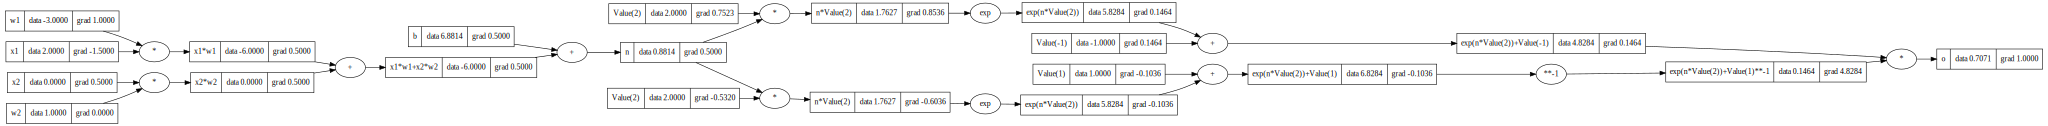

In [28]:
# inputs (stimuli)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights (synaptic strengths)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias (threshold)
b = Value(6.8813735870195432, label='b')

# Forward pass: tanh(x1*w1 + x2*w2 + b)
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); 
o = ((2 * n).exp() - 1) / ((2 * n).exp() + 1) # tanh function, equivalent to n.tanh()
o.label = 'o'

# Backward pass (manual gradient computation)
# o.grad = 1.0
# n.grad = 0.5 # = o.grad * (1.0 - o.data**2) # grad of tanh is (1 - tanh^2)
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# Backward pass using the _backward() method
o.backward()

o.draw_graph()